In [3]:
import pickle
import numpy as np
import os
import h5py
import openslide
import torch
import pandas as pd
from prototype_visualization_utils import get_panther_encoder, visualize_categorical_heatmap, get_mixture_plot, get_default_cmap
from mmp_visualization_utils import plot_pathomic_correspondence
import sys
sys.path.append('../')
from mil_models.tokenizer import PrototypeTokenizer

In [4]:
### Loading PANTHER Encoder
proto_path = '<path/to/prototype>.pkl'
panther_encoder = get_panther_encoder(in_dim=1024, p=16, proto_path=proto_path, config_dir='../configs')
panther_encoder.panther.H = 1

In [17]:
### Loading results pkl file from MMP training
results = pickle.load(open(f'<path/to/mmp saved results>.pkl', 'rb'))
for split, split_results in results.items():
    print(split)
    for k, v in split_results.items():
        print(f'\t{k}: {v.shape}')

### which samples to visualize
sample_ids = ['TCGA-A2-A0EY']
sample_id = sample_ids[0]
idxs = [np.where(results['test']['sample_ids']==sample_id)[0][0] for sample_id in sample_ids]
sampleid2idx = dict(zip(sample_ids, idxs))

### color map
color_map = get_default_cmap(16)
for k,v in get_default_cmap(16).items():
    color_map[15-k] = v
color_map_hex = get_default_cmap(16, return_hex=True)
for k,v in get_default_cmap(16, return_hex=True).items():
    color_map_hex[15-k] = v

display(color_map, color_map_hex)

train
	all_risk_scores: (700,)
	all_censorships: (700,)
	all_event_times: (700,)
	sample_ids: (700,)
	all_omic_attn: (700, 50, 50)
	all_cross_attn: (700, 50, 16)
	all_path_attn: (700, 16, 50)
test
	all_risk_scores: (168,)
	all_censorships: (168,)
	all_event_times: (168,)
	sample_ids: (168,)
	all_omic_attn: (168, 50, 50)
	all_cross_attn: (168, 50, 16)
	all_path_attn: (168, 16, 50)


{0: (255, 255, 84),
 1: (0, 255, 127),
 2: (138, 43, 226),
 3: (0, 255, 0),
 4: (255, 165, 0),
 5: (255, 0, 0),
 6: (176, 48, 96),
 7: (143, 188, 143),
 8: (127, 0, 127),
 9: (0, 0, 128),
 10: (0, 139, 139),
 11: (0, 128, 0),
 12: (72, 61, 139),
 13: (160, 82, 45),
 14: (85, 107, 47),
 15: (105, 105, 105)}

{0: '#FFFF54',
 1: '#00ff7f',
 2: '#8a2be2',
 3: '#00ff00',
 4: '#ffa500',
 5: '#ff0000',
 6: '#b03060',
 7: '#8fbc8f',
 8: '#7f007f',
 9: '#000080',
 10: '#008b8b',
 11: '#008000',
 12: '#483d8b',
 13: '#a0522d',
 14: '#556b2f',
 15: '#696969'}


Creating heatmap for: 
Top Left:  (0, 0) Bottom Right:  (112995, 91820)
Width: 3531, Height: 2869
Original Patch Size / Scaled Patch Size: (512, 512) / [16 16]
vis_level:  2
downsample:  32
region_size:  (3531, 2869)
total of 26802 patches


100%|██████████| 26802/26802 [00:01<00:00, 14088.86it/s]


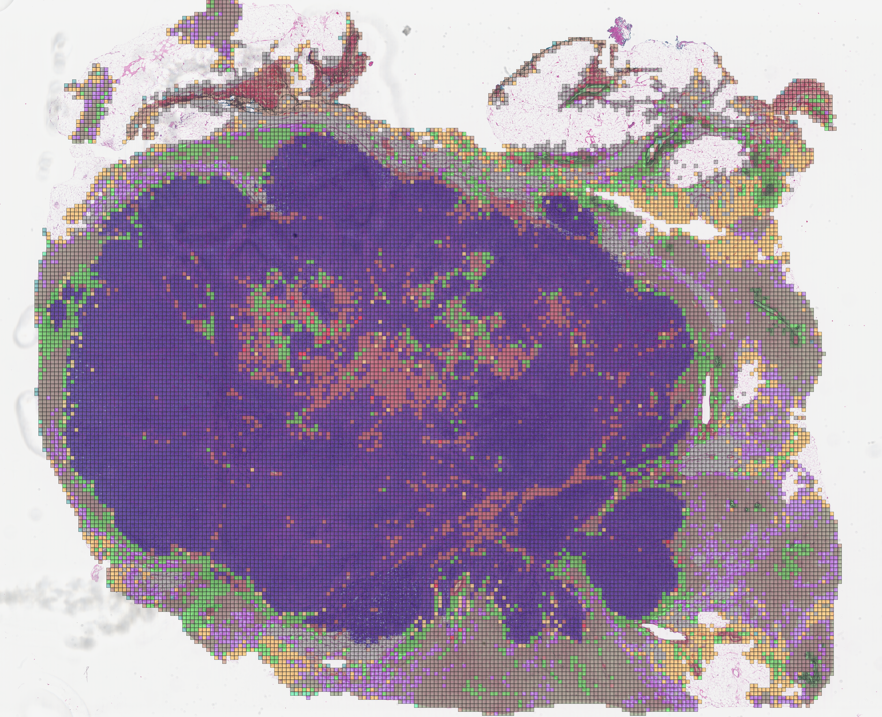

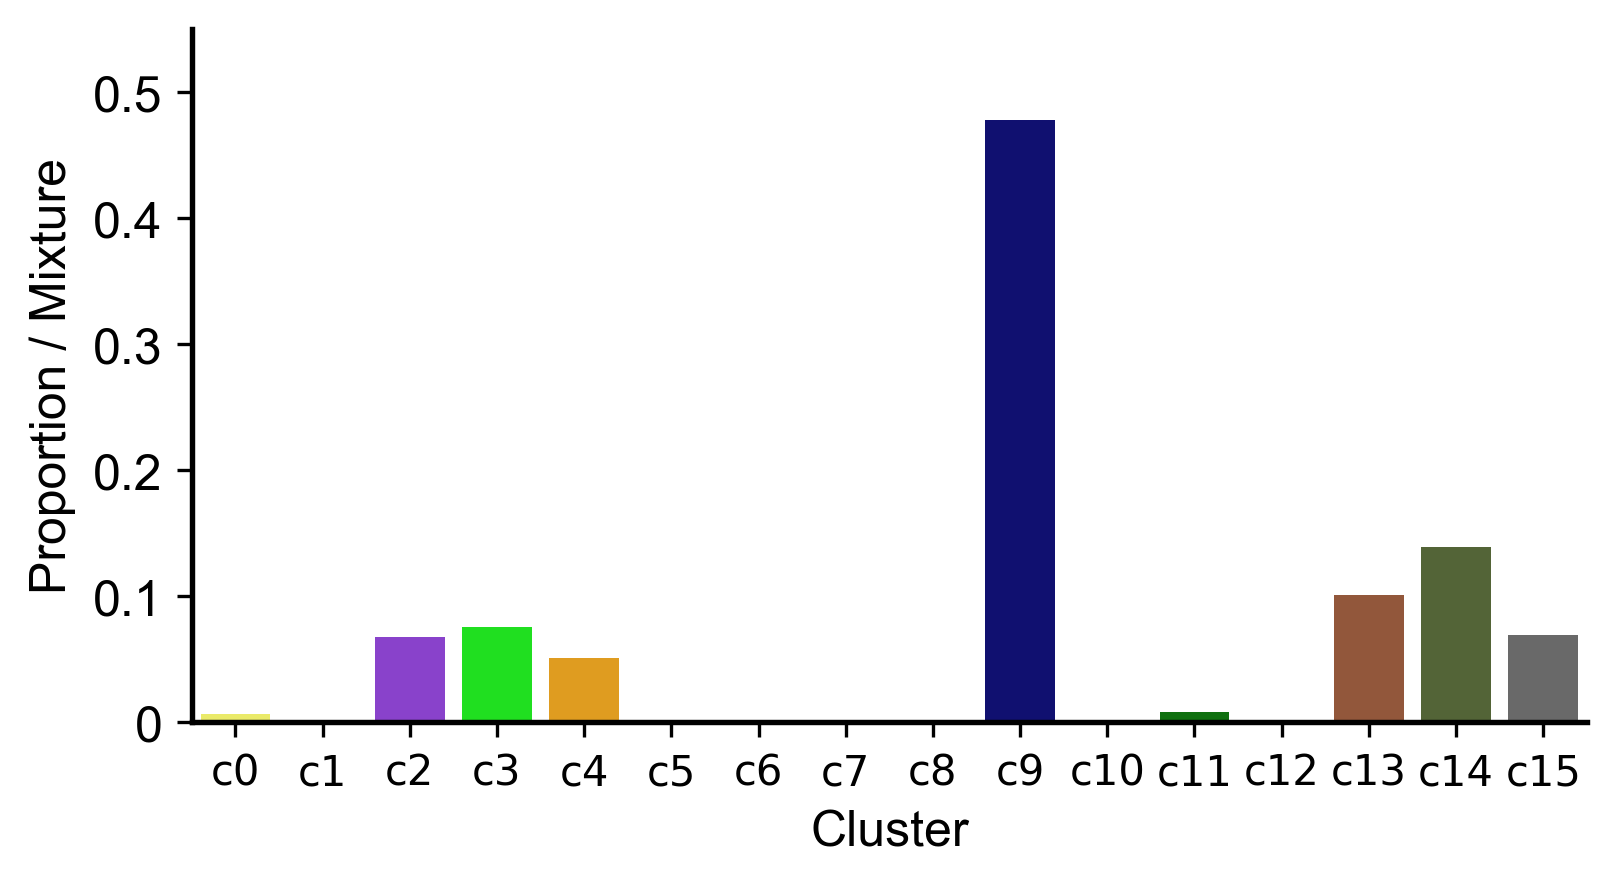

In [26]:
### open your WSI and features
slide_id = 'TCGA-A2-A0EY-01Z-00-DX1.2F2428B3-0767-48E0-AC22-443C244CBD16'
slide_fpath = f'<path/to/slide>/{slide_id}.svs'
h5_feats_fpath = f'<path/to/features>/{slide_id}.h5'
wsi = openslide.open_slide(slide_fpath)
h5 = h5py.File(h5_feats_fpath, 'r')

coords = h5['coords'][:]
feats = torch.Tensor(h5['features'][:])
custom_downsample = 2
patch_size = h5['coords'].attrs['patch_size'] * custom_downsample

### get PANTHER representation and GMM mixtures
with torch.inference_mode():
    out, qqs = panther_encoder.representation(feats).values()
    tokenizer = PrototypeTokenizer(p=16, out_type='allcat')
    mus, pis, sigmas = tokenizer.forward(out)
    mus = mus[0].detach().cpu().numpy()
    qq = qqs[0,:,:,0].cpu().numpy()
    global_cluster_labels = qq.argmax(axis=1)

### Visualize the categorical heatmap and the GMM mixtures
cat_map = visualize_categorical_heatmap(
    wsi,
    coords, 
    global_cluster_labels, 
    label2color_dict=color_map,
    vis_level=wsi.get_best_level_for_downsample(128),
    patch_size=(patch_size, patch_size),
    alpha=0.4,
)

display(cat_map.resize((cat_map.width//4, cat_map.height//4)))
display(get_mixture_plot(mus, colors=list(color_map_hex.values())))

In [73]:
### Loading hallmarks + initializing cluster identities
hallmarks = pd.read_csv('<path/to/mmp>/src/data_csvs/rna/metadata/hallmarks_signatures.csv')
hallmarks = sorted([' '.join(x[9:].split('_')) for x in hallmarks.columns])
cluster_ids = [f'C{i}' for i in range (16)]
cluster_identities = ['Tumor', 'Adipose/Connective', 'Connective', 'Connective', 'Adipose', 'Immune/Normal', 'Adipose/Tumor', 'Tumor', 'Tumor', 'Dense Tumor', 'Aritfacts', 'Normal Ducts/FEA', 'Dense Tumor', 'Tumor/Fat/Stroma', 'Normal', 'Tumor/Fat']
cluster_identities = dict(zip(cluster_ids, [x+' '+y for x,y in zip(cluster_ids, cluster_identities)]))

### idx corresponds to the index of the cross-attention weights that corresponds to sample_id
idx = sampleid2idx[sample_id]

### Loading cross-modal attention weights
cross_attn_path2omic = results['test']['all_cross_attn'][idx]
cross_attn_path2omic = torch.nn.Softmax(dim=1)(torch.Tensor(cross_attn_path2omic)).cpu().numpy()
cross_attn_path2omic = pd.DataFrame(cross_attn_path2omic, index=hallmarks, columns=cluster_identities.values())
print('cross_attn_path2omic shape:', cross_attn_path2omic.shape)
cross_attn_omic2path = results['test']['all_path_attn'][idx]
cross_attn_omic2path = torch.nn.Softmax(dim=1)(torch.Tensor(cross_attn_omic2path)).cpu().numpy()
cross_attn_omic2path = pd.DataFrame(cross_attn_omic2path, columns=hallmarks, index=cluster_ids)
print('cross_attn_omic2path shape:', cross_attn_omic2path.shape)
plot_dir = f'./{sample_id}/crossmodal'
os.makedirs(plot_dir, exist_ok=True)

### visualizing omic-to-path interactions
omic2path_viz = {}
for cluster in cross_attn_omic2path.index:
    omic2path = cross_attn_omic2path.loc[cluster].sort_values(ascending=False)
    omic2path_viz[cluster_identities[cluster]] = plot_pathomic_correspondence(
        omic2path, orient='v', color='#e7727a', 
        axis_lim=[0.0, 0.081], axis_tick=[0.0, 0.02, 0.04, 0.06, 0.08], lim=10)

### visualizing path-to-omic interactions
path2omic_viz = {}
for idx, omic in enumerate(cross_attn_path2omic.index):
    path2omic = cross_attn_path2omic.loc[omic].sort_values(ascending=False)
    path = os.path.join(plot_dir, f'cluster-to-hallmark{idx}-{"_".join(omic.lower().split(" "))}.png')
    path2omic_viz["_".join(omic.lower().split(" "))] = plot_pathomic_correspondence(path2omic, color='#8693e8')

cross_attn_path2omic shape: (50, 16)
cross_attn_omic2path shape: (16, 50)


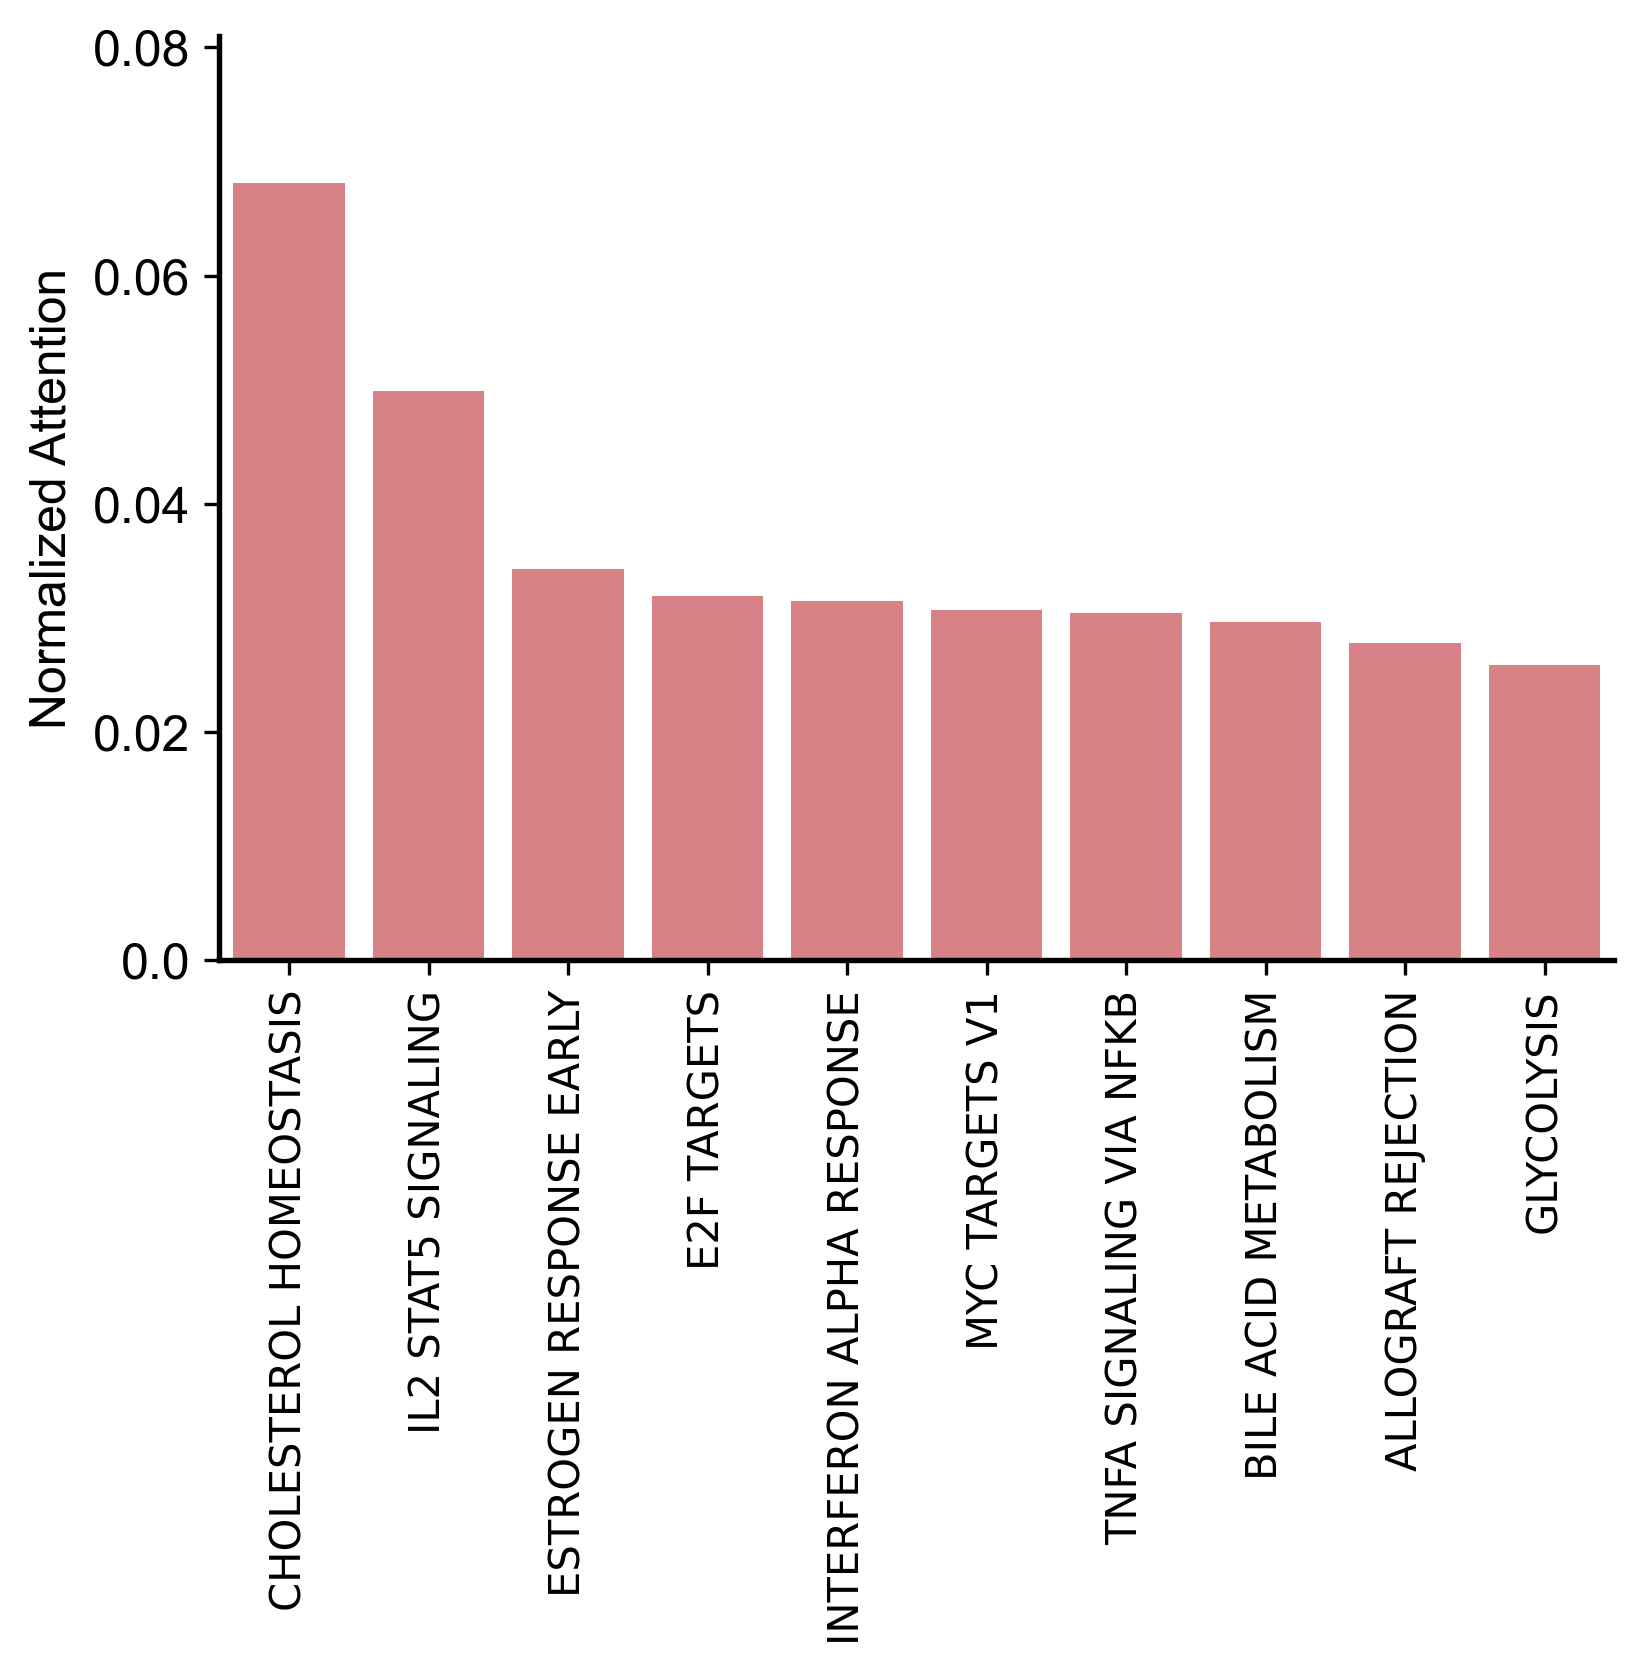

In [78]:
omic2path_viz['C12 Dense Tumor']

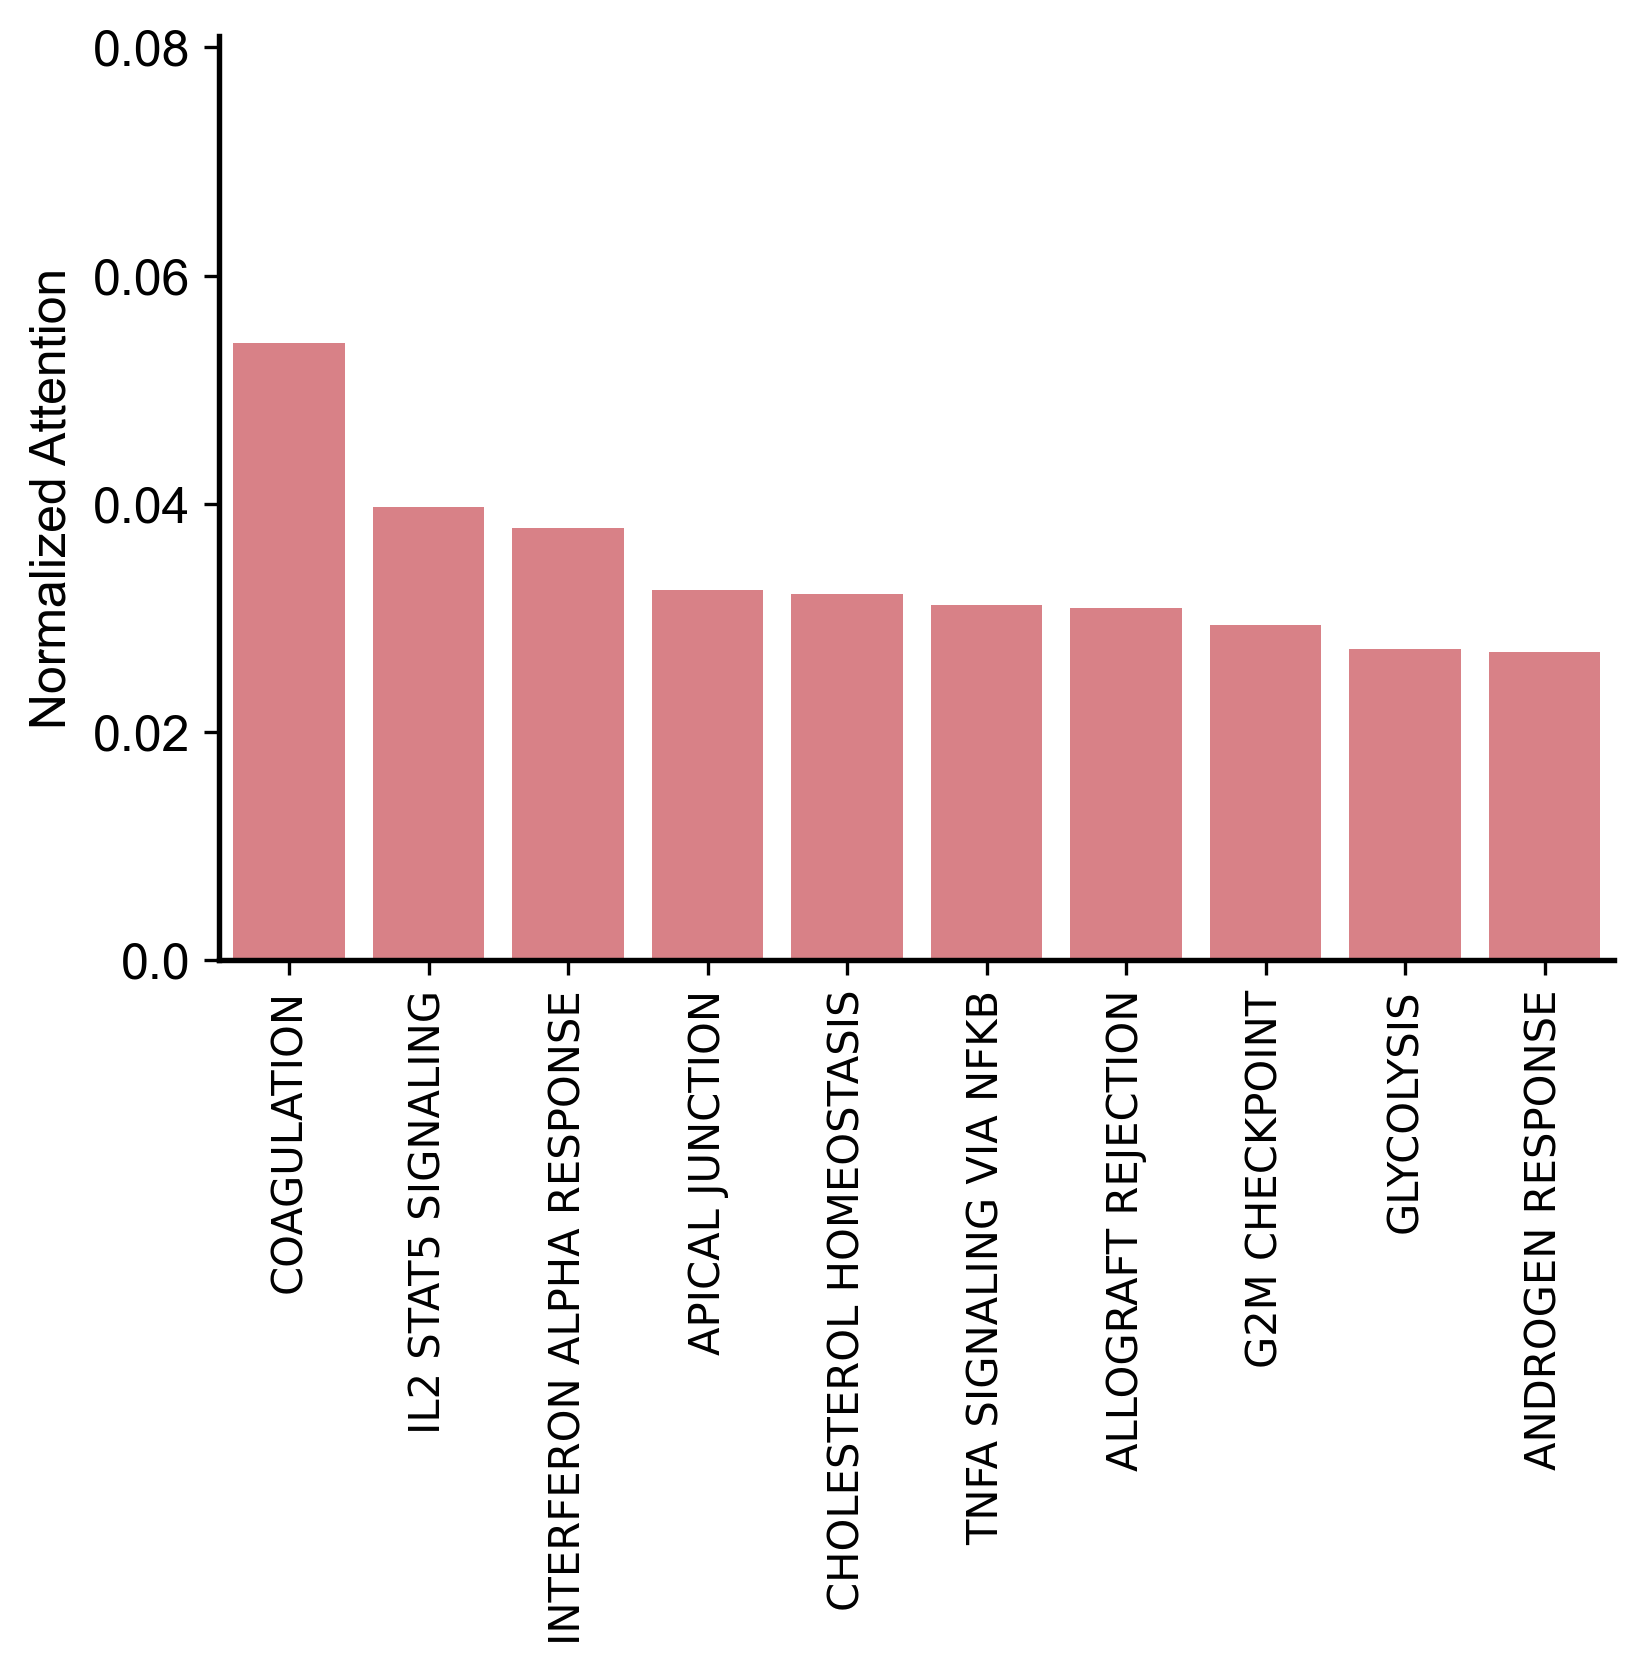

In [79]:
omic2path_viz['C15 Tumor/Fat']

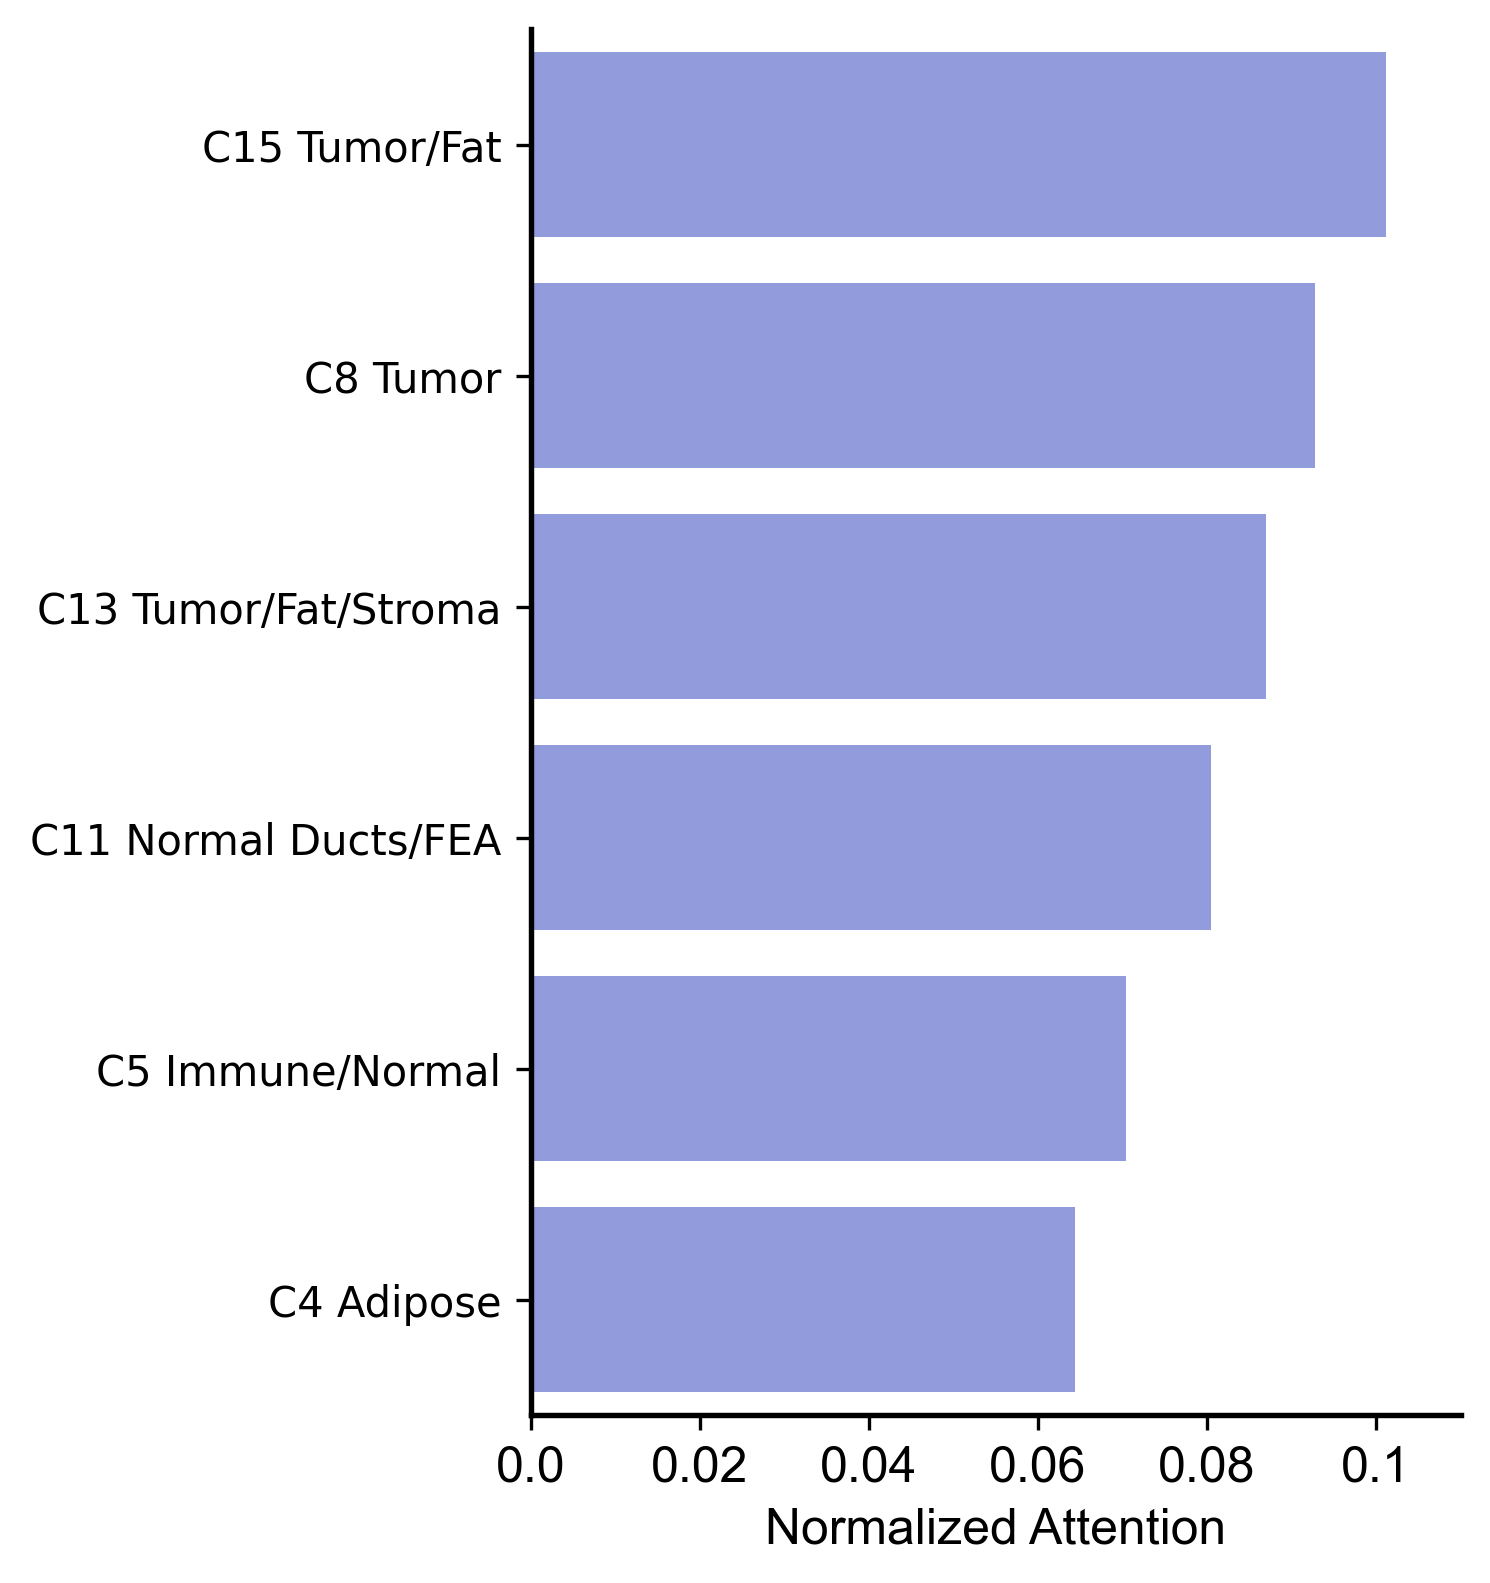

In [80]:
path2omic_viz['epithelial_mesenchymal_transition']

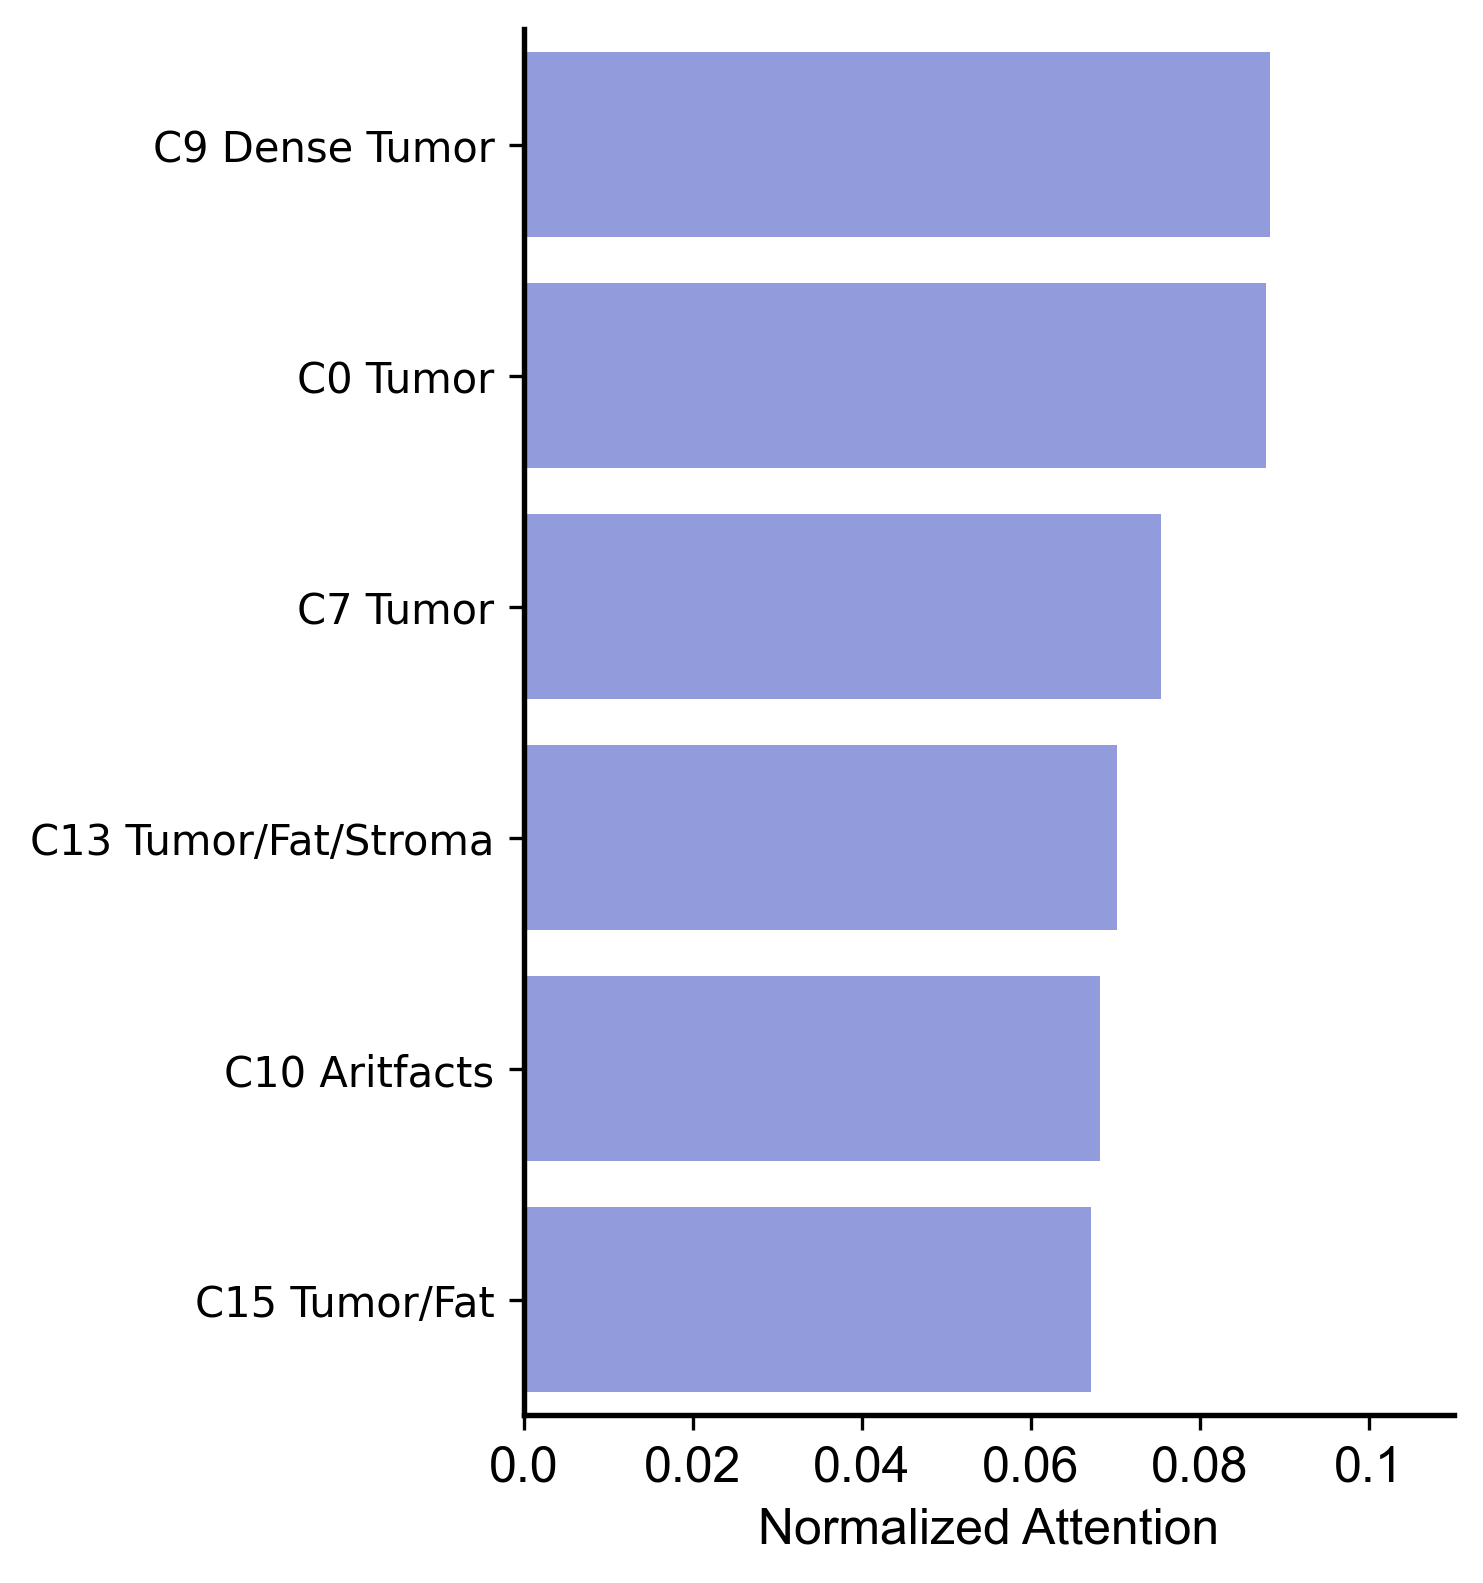

In [81]:
path2omic_viz['tnfa_signaling_via_nfkb']